# Lecture 1 Live Demo: Data Handling & Preprocessing

<!-- This notebook is built to fill a **45-minute live demo** in *Applied Machine Learning*. -->

<!-- **Design choice:** We do preprocessing primarily in **pandas**.  
We use scikit-learn for:
- train/test splitting
- simple baseline models
- basic metrics -->

<!-- The main pedagogical objective is to make every step **obvious**:
- *What are we doing?*
- *Why are we doing it?*
- *What could go wrong if we skip it?* -->

---

<!-- ## Suggested live pacing (45 minutes)
- **0–5 min**: What preprocessing is + why ML needs numeric `X`  
- **5–25 min**: Tabular data (Titanic) step-by-step (missing data, categories, outliers, scaling, “before vs after”)  
- **25–35 min**: Interactive demos (3 sliders) — the “aha moments”  
- **35–45 min**: Quick modality bridges (time series, text, images) + wrap-up

You can also run only Parts A + the 3 interactive demos if time is tight. -->


In [30]:
# =========================
# 0) Imports (small + reusable)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Minimal scikit-learn usage: splitting + simple models + basic metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error

# For interactive demos (sliders)
# !pip install ipywidgets
import ipywidgets as widgets
from ipywidgets import interact

# For the image example (optional bridge)
from io import BytesIO
import requests
from PIL import Image

pd.set_option("display.max_columns", 80)
pd.set_option("display.width", 160)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

%matplotlib inline


## 0) The core idea of preprocessing

Most ML algorithms expect:
- a numeric feature matrix **X** with shape `(n_samples, n_features)`
- a target vector **y** with shape `(n_samples,)`

So preprocessing is the practical work that turns:

**raw data** → **clean, numeric features**

We will repeatedly use this pipeline:
1. **Look at raw data** (small, human-readable slices)
2. **Diagnose issues** (missing values, strange ranges, outliers, categories)
3. **Apply a transformation** (impute, clip, encode, scale)
4. **Check effect** (plots + a tiny model sanity check)


### A note about interactive widgets

The interactive sections use **ipywidgets** (sliders).  
- In Jupyter Notebook/Lab, this usually works out-of-the-box.
- In VS Code, you may need the Jupyter + ipywidgets support enabled.

If sliders do not render, you can still run the non-interactive parts.


In [31]:
def safe_read_csv(url: str, **kwargs) -> pd.DataFrame:
    """Read CSV from a URL with a clear error message if the network is blocked."""
    try:
        return pd.read_csv(url, **kwargs)
    except Exception as e:
        raise RuntimeError(
            f"Could not read from URL:\n{url}\n\n"
            "If you are offline or blocked by a firewall, dataset loading will fail.\n\n"
            f"Original error: {type(e).__name__}: {e}"
        )


# Part A — Tabular data (Titanic): a full pandas-first pipeline

We start with a dataset that contains the most common “real world” problems:
- **Missing values** (e.g., age)
- **Categorical columns** (strings like sex/embarked)
- **Skew and outliers** (fare)

We will build a model-ready `X` step by step and show what changes.


In [32]:
TITANIC_URL = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/titanic.csv"
df_raw = safe_read_csv(TITANIC_URL)
df_raw.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## A1) First contact: create a *human* overview (no helper wall)

When you open a new dataset, do **only a few simple checks first**.
These are short, and you control the amount of output.

### Questions to answer
1. How big is the dataset? (`shape`)
2. What columns exist? (`columns`)
3. What types do they have? (`dtypes`)
4. What does a typical row look like? (`head()` / `sample()`)


In [33]:
print("Shape:", df_raw.shape)
print("\nA few random rows (to avoid looking only at the top):")
display(df_raw.sample(5, random_state=RANDOM_STATE))

print("\nColumn dtypes (what is numeric vs categorical?):")
display(df_raw.dtypes)


Shape: (891, 15)

A few random rows (to avoid looking only at the top):


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
709,1,3,male,NaN,1,1,15.2458,C,Third,man,True,NaN,Cherbourg,yes,False
439,0,2,male,31.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,no,True
840,0,3,male,20.0,0,0,7.9250,S,Third,man,True,NaN,Southampton,no,True
720,1,2,female,6.0,0,1,33.0000,S,Second,child,False,NaN,Southampton,yes,False
39,1,3,female,14.0,1,0,11.2417,C,Third,child,False,NaN,Cherbourg,yes,False



Column dtypes (what is numeric vs categorical?):


survived         int64
pclass           int64
sex             object
age            float64
sibsp            int64
parch            int64
fare           float64
embarked        object
class           object
who             object
adult_male        bool
deck            object
embark_town     object
alive           object
alone             bool
dtype: object

---
## Titanic dataset — column reference

| Column | Type | Meaning | Notes for ML |
|--------|------|---------|--------------|
| `survived` | Binary (0/1) | Whether the passenger survived | **Target variable** |
| `pclass` | Categorical (1, 2, 3) | Passenger class (1 = highest) | Proxy for socio-economic status |
| `sex` | Categorical | Passenger sex (`male`, `female`) | Strong predictor |
| `age` | Numeric (years) | Passenger age | Missing values present |
| `sibsp` | Integer | Number of siblings / spouses aboard | Family structure |
| `parch` | Integer | Number of parents / children aboard | Family structure |
| `fare` | Numeric | Ticket price | Highly skewed distribution |
| `embarked` | Categorical (`S`, `C`, `Q`) | Port of embarkation | Missing values present |
| `class` | Categorical | Passenger class (`First`, `Second`, `Third`) | **Redundant with `pclass`** |
| `who` | Categorical | Passenger group (`man`, `woman`, `child`) | Derived from `age` + `sex` |
| `adult_male` | Boolean | Is the passenger an adult male | Highly correlated with `sex` |
| `deck` | Categorical (`A`–`G`) | Deck location | Many missing values |
| `embark_town` | Categorical | Full name of embarkation port | Redundant with `embarked` |
| `alive` | Categorical (`yes`, `no`) | Survival outcome | **Redundant with `survived`** |
| `alone` | Boolean | No family aboard (`sibsp + parch == 0`) | Engineered feature |

---

### Important notes

- Several columns contain **duplicate information**  
  (`class` ↔ `pclass`, `alive` ↔ `survived`)
- Some features are **derived**, not raw measurements  
  (`who`, `adult_male`, `alone`)
- Using multiple correlated features can cause **information leakage**
- Missing values are **systematic**, not random (especially `age` and `deck`)

---



## A2) Missing values: *where* and *how much*?

Missing values are one of the first things that can break ML training.

We compute missingness as a *fraction per column*:
- 0.0  → no missing values
- 0.25 → 25% missing values


deck           0.772166
age            0.198653
embarked       0.002245
embark_town    0.002245
survived       0.000000
pclass         0.000000
sex            0.000000
sibsp          0.000000
parch          0.000000
fare           0.000000
class          0.000000
who            0.000000
adult_male     0.000000
alive          0.000000
alone          0.000000
dtype: float64

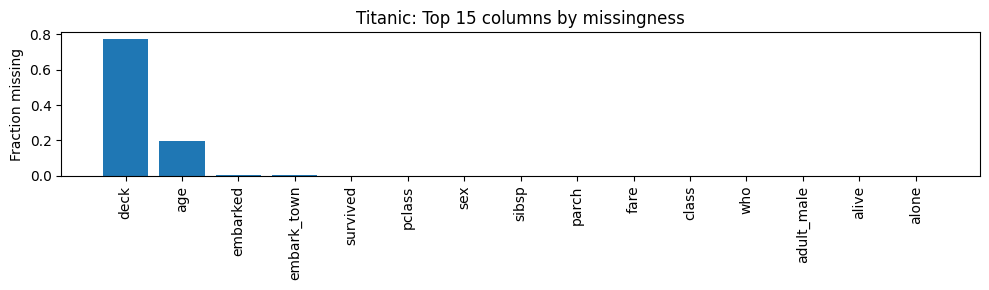

In [34]:
missing_frac = df_raw.isna().mean().sort_values(ascending=False)
display(missing_frac.head(15))

plt.figure(figsize=(10, 3))
plt.bar(missing_frac.index[:15].astype(str), missing_frac.values[:15])
plt.title("Titanic: Top 15 columns by missingness")
plt.ylabel("Fraction missing")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


## A3) Focus the scope (avoid “everything everywhere”)

We choose a smaller set of features plus the target.

Target: `survived` (0/1)

Features include:
- numeric: `age`, `fare`, ...
- categorical: `sex`, `embarked`, ...


In [35]:
target_col = "survived"
feature_cols = ["pclass","sex","age","sibsp","parch","fare","embarked","class","who","adult_male","alone"]

df = df_raw[feature_cols + [target_col]].copy()
df.head()


,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alone,survived
0,3,male,22.0,1,0,7.2500,S,Third,man,True,False,0
1,1,female,38.0,1,0,71.2833,C,First,woman,False,False,1
2,3,female,26.0,0,0,7.9250,S,Third,woman,False,True,1
3,1,female,35.0,1,0,53.1000,S,First,woman,False,False,1
4,3,male,35.0,0,0,8.0500,S,Third,man,True,True,0


## A4) Visual diagnostics: distributions (missing + outliers become obvious)

Two plots explain a lot:
- **Histogram**: shape/skew
- **Boxplot**: outliers

We examine:
- `age` (missing values)
- `fare` (skew + outliers)


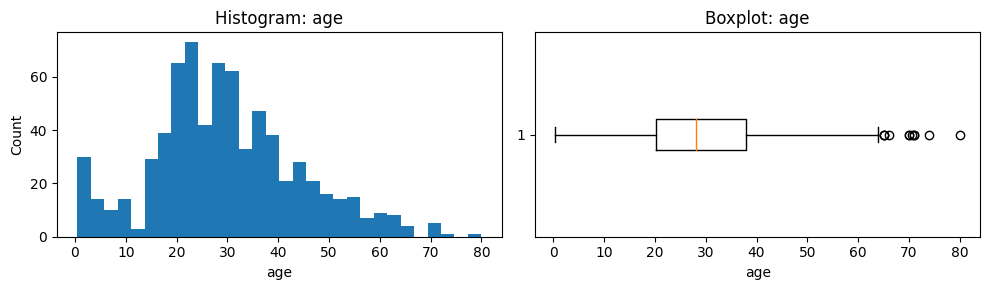

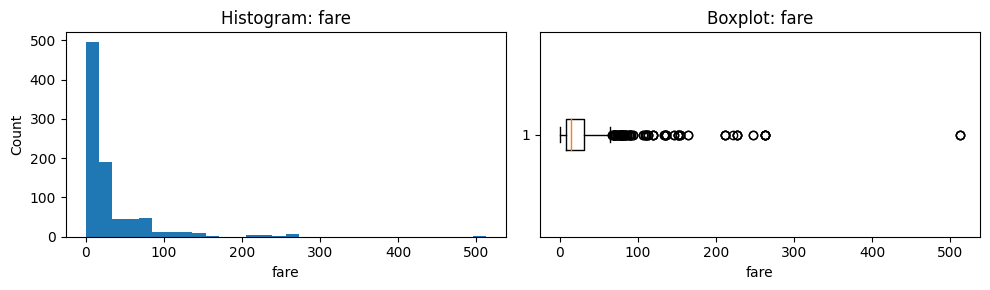

In [36]:
def hist_and_box(series: pd.Series, name: str, bins: int = 30):
    """A minimal visual diagnostic: histogram + boxplot."""
    x = series.dropna()
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.hist(x, bins=bins)
    plt.title(f"Histogram: {name}")
    plt.xlabel(name)
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.boxplot(x, vert=False)
    plt.title(f"Boxplot: {name}")
    plt.xlabel(name)
    plt.tight_layout()
    plt.show()

hist_and_box(df["age"], "age")
hist_and_box(df["fare"], "fare")


## A5) Baseline model (intentionally naive): drop missing rows + one-hot

This is a common beginner baseline because it is easy:
1. split train/test
2. drop rows with missing values
3. one-hot encode categoricals (pandas `get_dummies`)
4. train logistic regression

**Notice:** dropping rows can throw away many samples.


Naive baseline accuracy: 0.8305084745762712
Train samples used: 535 / 668
Test samples used : 177 / 223


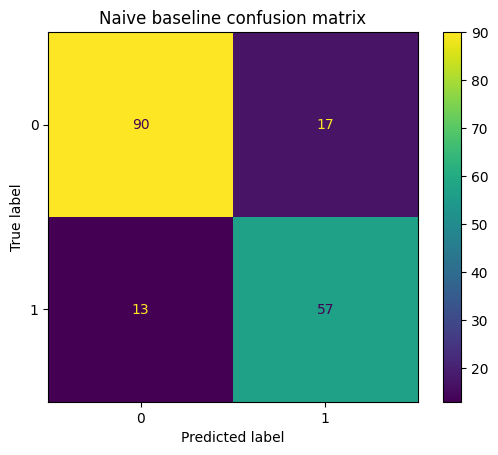

In [51]:
# 1) Split first (important habit to avoid leakage later)
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

# 2) Drop missing rows (naive)
train_naive = X_train.join(y_train).dropna()
test_naive  = X_test.join(y_test).dropna()

X_train_naive = train_naive.drop(columns=[target_col])
y_train_naive = train_naive[target_col]
X_test_naive  = test_naive.drop(columns=[target_col])
y_test_naive  = test_naive[target_col]

# 3) One-hot encode with pandas
X_train_naive_ohe = pd.get_dummies(X_train_naive, drop_first=True)
X_test_naive_ohe  = pd.get_dummies(X_test_naive, drop_first=True)

# 4) Align columns (critical! categories can differ between train and test)
X_train_naive_ohe, X_test_naive_ohe = X_train_naive_ohe.align(X_test_naive_ohe, join="left", axis=1, fill_value=0)

# 5) Train a simple model
model_naive = LogisticRegression(max_iter=2000)
model_naive.fit(X_train_naive_ohe, y_train_naive)
pred_naive = model_naive.predict(X_test_naive_ohe)

acc_naive = accuracy_score(y_test_naive, pred_naive)
print("Naive baseline accuracy:", acc_naive)
print("Train samples used:", len(X_train_naive), "/", len(X_train))
print("Test samples used :", len(X_test_naive),  "/", len(X_test))

ConfusionMatrixDisplay(confusion_matrix(y_test_naive, pred_naive)).plot()
plt.title("Naive baseline confusion matrix")
plt.show()


## A6) Missing value imputation (pandas): keep more data

Instead of dropping rows, we **impute** missing values.

### Strategy (simple and explainable)
- numeric columns: fill with **median** (robust to outliers)
- categorical columns: fill with **mode** (most frequent value)

**Important rule:** compute fill values on the **training set only**, then apply to train and test.


In [52]:
# Identify numeric vs categorical columns in a pandas-first way
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# Compute fill values on TRAIN only (avoid leakage)
num_fill = X_train[numeric_cols].median()
cat_fill = X_train[categorical_cols].mode().iloc[0]

# Apply to both train and test
X_train_imp = X_train.copy()
X_test_imp  = X_test.copy()

X_train_imp[numeric_cols] = X_train_imp[numeric_cols].fillna(num_fill)
X_test_imp[numeric_cols]  = X_test_imp[numeric_cols].fillna(num_fill)

X_train_imp[categorical_cols] = X_train_imp[categorical_cols].fillna(cat_fill)
X_test_imp[categorical_cols]  = X_test_imp[categorical_cols].fillna(cat_fill)

print("Total missing after imputation (train):", int(X_train_imp.isna().sum().sum()))
print("Total missing after imputation (test):", int(X_test_imp.isna().sum().sum()))


Numeric: ['pclass', 'age', 'sibsp', 'parch', 'fare']
Categorical: ['sex', 'embarked', 'class', 'who', 'adult_male', 'alone']
Total missing after imputation (train): 0
Total missing after imputation (test): 0


## A7) Outliers: a simple pandas approach (clipping / winsorization)

For skewed numeric columns, extreme values can dominate statistics and sometimes models.

A simple, explainable technique:
1. choose percentile thresholds on **train**
2. clip values outside those thresholds on both train and test

We demonstrate on `fare`.


Fare clip thresholds: 0.0 227.525


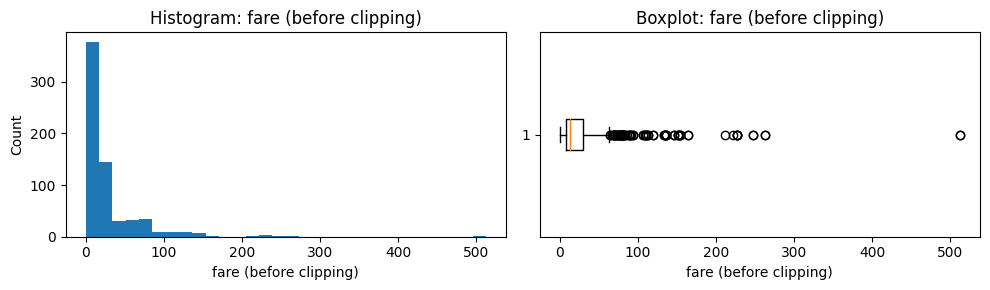

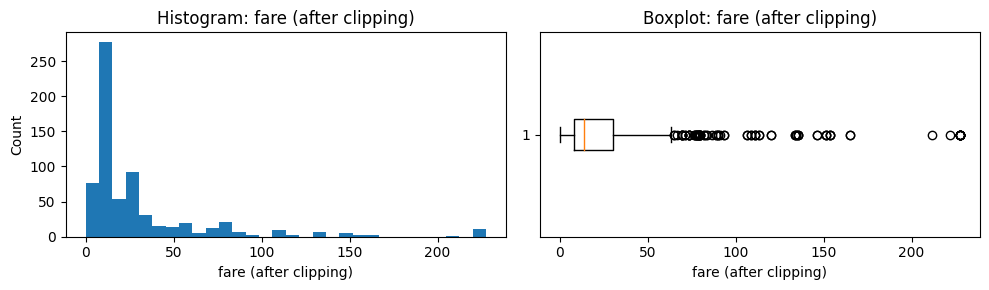

In [53]:
# Choose clipping thresholds on TRAIN only
col = "fare"
lo, hi = X_train_imp[col].quantile([0.01, 0.99])
print("Fare clip thresholds:", float(lo), float(hi))

X_train_clip = X_train_imp.copy()
X_test_clip  = X_test_imp.copy()

X_train_clip[col] = X_train_clip[col].clip(lo, hi)
X_test_clip[col]  = X_test_clip[col].clip(lo, hi)

# Visualize effect on the training distribution
hist_and_box(X_train_imp[col], "fare (before clipping)")
hist_and_box(X_train_clip[col], "fare (after clipping)")


## A8) Scaling (pandas): make numeric features comparable

Scaling is often helpful when:
- features have very different units (e.g., meters vs volts)
- the model uses distances or regularization (you will see this later)

We implement two easy-to-explain scalers in pandas:

### Z-score standardization
$$
z = \frac{x - \mu}{\sigma}
$$

### Robust scaling (median/IQR)
$$
x' = \frac{x - \text{median}(x)}{\text{IQR}(x)}
$$

Again: compute parameters on **train**, apply to both.


Clean pipeline accuracy (impute+clip+scale+one-hot): 0.820627802690583


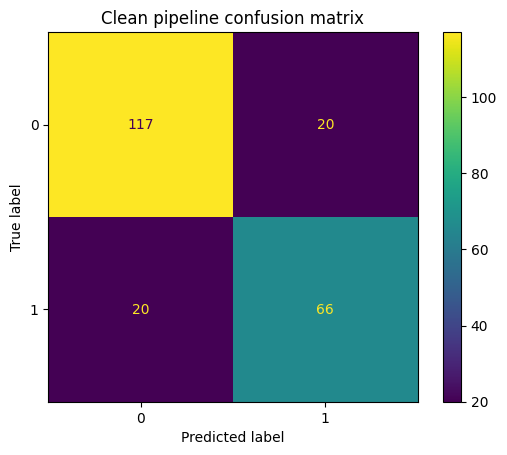

In [40]:
def zscore_scale(train_df: pd.DataFrame, test_df: pd.DataFrame, cols: list[str]):
    mu = train_df[cols].mean()
    sigma = train_df[cols].std(ddof=0).replace(0, 1.0)
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    train_scaled[cols] = (train_df[cols] - mu) / sigma
    test_scaled[cols] = (test_df[cols] - mu) / sigma
    return train_scaled, test_scaled

def robust_scale(train_df: pd.DataFrame, test_df: pd.DataFrame, cols: list[str]):
    med = train_df[cols].median()
    iqr = (train_df[cols].quantile(0.75) - train_df[cols].quantile(0.25)).replace(0, 1.0)
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    train_scaled[cols] = (train_df[cols] - med) / iqr
    test_scaled[cols] = (test_df[cols] - med) / iqr
    return train_scaled, test_scaled

# Use z-score scaling for the main pipeline (easiest for first lecture)
X_train_scaled, X_test_scaled = zscore_scale(X_train_clip, X_test_clip, numeric_cols)

# One-hot encode categoricals, then align columns (same pattern as before)
X_train_ohe = pd.get_dummies(X_train_scaled, drop_first=True)
X_test_ohe  = pd.get_dummies(X_test_scaled, drop_first=True)
X_train_ohe, X_test_ohe = X_train_ohe.align(X_test_ohe, join="left", axis=1, fill_value=0)

model_clean = LogisticRegression(max_iter=2000)
model_clean.fit(X_train_ohe, y_train)
pred_clean = model_clean.predict(X_test_ohe)

acc_clean = accuracy_score(y_test, pred_clean)
print("Clean pipeline accuracy (impute+clip+scale+one-hot):", acc_clean)

ConfusionMatrixDisplay(confusion_matrix(y_test, pred_clean)).plot()
plt.title("Clean pipeline confusion matrix")
plt.show()


## A5 vs A8 — Which preprocessing strategy works best?

We compare two end-to-end pipelines on the same dataset:

- **A5 (Naive baseline):** drop rows with missing values → one-hot → Logistic Regression  
- **A8 (Clean pipeline):** impute (train stats) + clip outliers + scale numeric features + one-hot → Logistic Regression

**What to look for:**
- Accuracy (overall performance)
- Confusion matrix structure: are we reducing **false negatives** or **false positives**?
- Note that A5 uses **fewer samples**, which can make the comparison misleading if missingness is not random.


A5 (naive baseline): accuracy = 0.8305  | test n = 177
A8 (clean pipeline): accuracy = 0.8206  | test n = 223
Δ accuracy (A8 − A5) = -0.0099


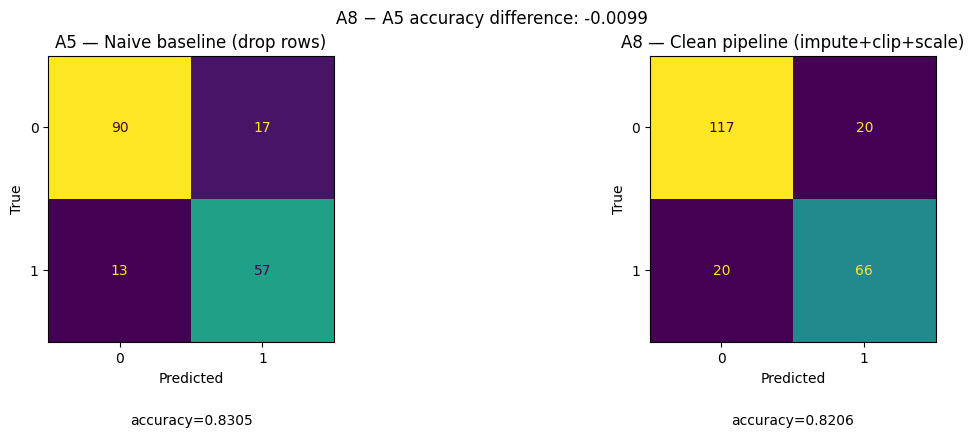

In [56]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def show_cm_side_by_side(
    y_true_a5, y_pred_a5, acc_a5, n_train_a5=None, n_test_a5=None,
    y_true_a8=None, y_pred_a8=None, acc_a8=None, n_train_a8=None, n_test_a8=None,
    labels=None,
    titles=("A5 — Naive baseline (drop rows)", "A8 — Clean pipeline (impute+clip+scale)"),
):
    """
    Lecture-friendly comparison plot for two confusion matrices + headline stats.
    Assumes binary classification (labels=[0,1]) unless provided.
    """
    if labels is None:
        labels = np.unique(np.concatenate([np.unique(y_true_a5), np.unique(y_true_a8)]))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # ---- A5 ----
    cm_a5 = confusion_matrix(y_true_a5, y_pred_a5, labels=labels)
    ConfusionMatrixDisplay(cm_a5, display_labels=labels).plot(ax=axes[0], values_format="d", colorbar=False)
    axes[0].set_title(titles[0])
    subtitle_a5 = f"accuracy={acc_a5:.4f}"
    if n_train_a5 is not None and n_test_a5 is not None:
        subtitle_a5 += f"\ntrain={n_train_a5}, test={n_test_a5}"
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("True")
    axes[0].text(0.5, -0.25, subtitle_a5, transform=axes[0].transAxes, ha="center", va="top")

    # ---- A8 ----
    cm_a8 = confusion_matrix(y_true_a8, y_pred_a8, labels=labels)
    ConfusionMatrixDisplay(cm_a8, display_labels=labels).plot(ax=axes[1], values_format="d", colorbar=False)
    axes[1].set_title(titles[1])
    subtitle_a8 = f"accuracy={acc_a8:.4f}"
    if n_train_a8 is not None and n_test_a8 is not None:
        subtitle_a8 += f"\ntrain={n_train_a8}, test={n_test_a8}"
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("True")
    axes[1].text(0.5, -0.25, subtitle_a8, transform=axes[1].transAxes, ha="center", va="top")

    # Headline text
    delta = acc_a8 - acc_a5
    fig.suptitle(f"A8 − A5 accuracy difference: {delta:+.4f}", y=1.05, fontsize=12)

    plt.show()


# ==========================
# EXPECTED VARIABLES FROM YOUR NOTEBOOK
# ==========================
# A5 / naive:
#   acc_naive, y_test_naive, pred_naive
# (optionally) n_train_naive, n_test_naive  OR infer from arrays
#
# A8 / clean:
#   acc_clean, y_test, pred_clean

# Infer counts (works even if you don't have explicit n_train variables)
n_test_naive = len(y_test_naive)
n_test_clean = len(y_test)

# If you have explicit train sizes, put them here; otherwise set to None
n_train_naive = globals().get("n_train_naive", None)
n_train_clean = globals().get("n_train_clean", None)

print(f"A5 (naive baseline): accuracy = {acc_naive:.4f}  | test n = {n_test_naive}")
print(f"A8 (clean pipeline): accuracy = {acc_clean:.4f}  | test n = {n_test_clean}")
print(f"Δ accuracy (A8 − A5) = {acc_clean - acc_naive:+.4f}")

show_cm_side_by_side(
    y_true_a5=y_test_naive, y_pred_a5=pred_naive, acc_a5=acc_naive,
    n_train_a5=n_train_naive, n_test_a5=n_test_naive,
    y_true_a8=y_test, y_pred_a8=pred_clean, acc_a8=acc_clean,
    n_train_a8=n_train_clean, n_test_a8=n_test_clean,
    labels=[0, 1],
)


## Fair comparison: evaluate both models on the *same* test samples

In the previous comparison, A5 (drop rows) evaluated on fewer test samples because it removed rows with missing values.

To make the comparison fair, we evaluate **both pipelines on exactly the same subset of the test set**:
the **complete-case** subset (rows without missing values).

This isolates the effect of preprocessing/modeling from the effect of *which samples are included*.


Common test set size (no missing rows): 177 / 223
A5 accuracy on common test set: 0.8305
A8 accuracy on common test set: 0.8249
Δ accuracy (A8 − A5) on common set: -0.0056


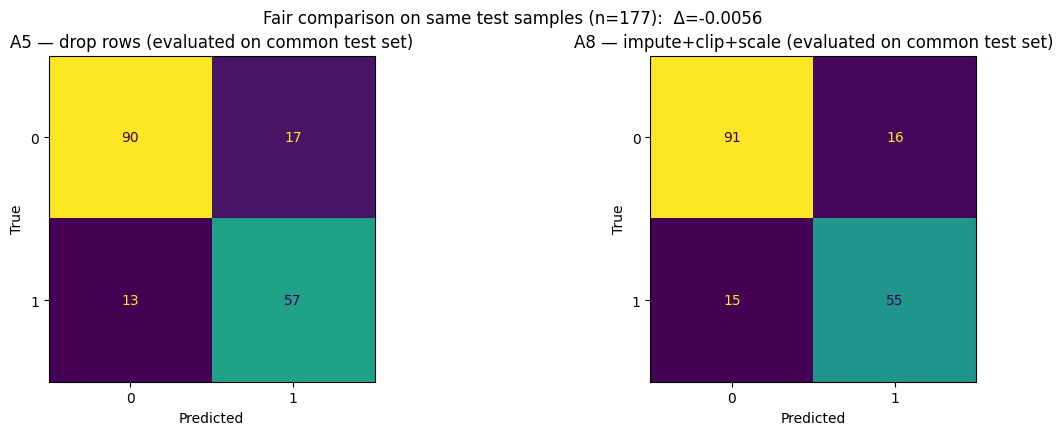

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# ---------------------------------------------------------
# 1) Define a shared test set: rows with NO missing values
# ---------------------------------------------------------
# Use X_test and y_test (the original split from the notebook)
mask_complete = ~X_test.isna().any(axis=1)

X_test_common = X_test.loc[mask_complete].copy()
y_test_common = y_test.loc[mask_complete].copy()

print(f"Common test set size (no missing rows): {len(X_test_common)} / {len(X_test)}")

# ---------------------------------------------------------
# 2) Evaluate A5 model (trained on dropna rows) on common set
#    Requires pred_naive to have been produced earlier OR
#    re-fit + predict here. We'll do re-predict robustly.
# ---------------------------------------------------------
# We assume you already created model_naive / clf_naive and columns
# If not, we will fall back to re-fitting quickly using your A5 logic.

def fit_a5_drop_rows(X_train, y_train):
    train_naive = X_train.join(y_train).dropna()
    Xtr = train_naive.drop(columns=[target_col])
    ytr = train_naive[target_col]

    Xtr_ohe = pd.get_dummies(Xtr, drop_first=True)

    model = LogisticRegression(max_iter=2000)
    model.fit(Xtr_ohe, ytr)
    return model, Xtr_ohe.columns

def predict_with_columns(model, cols, X_df):
    X_ohe = pd.get_dummies(X_df, drop_first=True)
    X_ohe = X_ohe.reindex(columns=cols, fill_value=0)
    return model.predict(X_ohe)

# A5 model + columns (use existing if present)
model_naive = globals().get("model_naive", None)
cols_naive  = globals().get("cols_naive", None)

if model_naive is None or cols_naive is None:
    from sklearn.linear_model import LogisticRegression
    model_naive, cols_naive = fit_a5_drop_rows(X_train, y_train)

pred_a5_common = predict_with_columns(model_naive, cols_naive, X_test_common)
acc_a5_common = accuracy_score(y_test_common, pred_a5_common)

# ---------------------------------------------------------
# 3) Evaluate A8 model on the SAME common set
#    (impute + clip + scale based on TRAIN statistics)
# ---------------------------------------------------------
# We assume your notebook already computed:
# - numeric_cols, categorical_cols
# - num_fill, cat_fill
# - lo, hi for fare clipping
# - mu, sigma for scaling
# If not, recompute from X_train (train-only statistics).

numeric_cols = globals().get("numeric_cols", X_train.select_dtypes(include=["number"]).columns.tolist())
categorical_cols = globals().get("categorical_cols", [c for c in X_train.columns if c not in numeric_cols])

num_fill = globals().get("num_fill", X_train[numeric_cols].median())
cat_fill = globals().get("cat_fill", X_train[categorical_cols].mode().iloc[0])

# Prepare common test with A8 preprocessing
X_test_a8_common = X_test_common.copy()
X_test_a8_common[numeric_cols] = X_test_a8_common[numeric_cols].fillna(num_fill)
X_test_a8_common[categorical_cols] = X_test_a8_common[categorical_cols].fillna(cat_fill)

# Clip fare (train-only)
col = "fare"
if col in X_train.columns:
    # compute quantiles on imputed TRAIN set
    X_train_imp = X_train.copy()
    X_train_imp[numeric_cols] = X_train_imp[numeric_cols].fillna(num_fill)
    X_train_imp[categorical_cols] = X_train_imp[categorical_cols].fillna(cat_fill)
    lo, hi = X_train_imp[col].quantile([0.01, 0.99])

    X_test_a8_common[col] = X_test_a8_common[col].clip(lo, hi)

# Scale numeric (train-only)
mu = globals().get("mu", None)
sigma = globals().get("sigma", None)
if mu is None or sigma is None:
    # compute on clipped+imputed TRAIN
    X_train_clip = X_train_imp.copy()
    if col in X_train.columns:
        X_train_clip[col] = X_train_clip[col].clip(lo, hi)

    mu = X_train_clip[numeric_cols].mean()
    sigma = X_train_clip[numeric_cols].std(ddof=0).replace(0, 1.0)

X_test_a8_common[numeric_cols] = (X_test_a8_common[numeric_cols] - mu) / sigma

# Predict with A8 model (use existing if present, else fit quickly)
model_clean = globals().get("model_clean", None)
cols_clean  = globals().get("cols_clean", None)

def fit_a8_clean_pipeline(X_train, y_train):
    # impute
    Xtr = X_train.copy()
    Xtr[numeric_cols] = Xtr[numeric_cols].fillna(num_fill)
    Xtr[categorical_cols] = Xtr[categorical_cols].fillna(cat_fill)

    # clip
    if col in Xtr.columns:
        Xtr[col] = Xtr[col].clip(lo, hi)

    # scale
    Xtr[numeric_cols] = (Xtr[numeric_cols] - mu) / sigma

    # ohe
    Xtr_ohe = pd.get_dummies(Xtr, drop_first=True)

    model = LogisticRegression(max_iter=2000)
    model.fit(Xtr_ohe, y_train)
    return model, Xtr_ohe.columns

if model_clean is None or cols_clean is None:
    from sklearn.linear_model import LogisticRegression
    model_clean, cols_clean = fit_a8_clean_pipeline(X_train, y_train)

pred_a8_common = predict_with_columns(model_clean, cols_clean, X_test_a8_common)
acc_a8_common = accuracy_score(y_test_common, pred_a8_common)

# ---------------------------------------------------------
# 4) Print + plot confusion matrices side-by-side
# ---------------------------------------------------------
print(f"A5 accuracy on common test set: {acc_a5_common:.4f}")
print(f"A8 accuracy on common test set: {acc_a8_common:.4f}")
print(f"Δ accuracy (A8 − A5) on common set: {acc_a8_common - acc_a5_common:+.4f}")

labels = [0, 1]
fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

cm_a5 = confusion_matrix(y_test_common, pred_a5_common, labels=labels)
ConfusionMatrixDisplay(cm_a5, display_labels=labels).plot(ax=axes[0], values_format="d", colorbar=False)
axes[0].set_title("A5 — drop rows (evaluated on common test set)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

cm_a8 = confusion_matrix(y_test_common, pred_a8_common, labels=labels)
ConfusionMatrixDisplay(cm_a8, display_labels=labels).plot(ax=axes[1], values_format="d", colorbar=False)
axes[1].set_title("A8 — impute+clip+scale (evaluated on common test set)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

fig.suptitle(f"Fair comparison on same test samples (n={len(X_test_common)}):  Δ={acc_a8_common-acc_a5_common:+.4f}", y=1.05)
plt.show()


### Interpretation

Now both models are evaluated on the **exact same test samples** (complete cases only).
This removes the “coverage effect” (A5 dropping test rows) and makes the comparison fair.

If A5 still performs better here, it suggests that the additional preprocessing in A8
(imputation/clipping/scaling) is not improving this particular model on this subset.

However, in real deployments we usually care about **coverage** as well:
a pipeline that can predict for *all* incoming data is often preferable.


### Titanic: what students should take away

1. You can do most preprocessing in **pandas**.
2. The workflow is: **inspect → decide → transform → verify**.
3. Two critical “ML engineering” habits:
   - split train/test early
   - compute preprocessing parameters on train only, then apply to test
4. For categoricals, you must keep train/test feature columns consistent:
   `get_dummies(...)` + `align(...)`


# Part B — Interactive demos 

These demos are designed to make preprocessing feel *necessary*, not optional.

Each demo lets you change one aspect of “messiness” and immediately see:
- how the data distribution changes
- how a simple model metric changes

We keep everything **small** and **explainable**.


# Demo — Missing data: what changes, what breaks, and what the model actually computes

We build a synthetic binary classification dataset with two features:

- `x1 ~ N(0,1)`
- `x2 ~ N(0,1)`

and a target `y` defined by a noisy linear rule:

$$
y = \mathbb{1}\left( x_1 + 0.8x_2 + \varepsilon > 0 \right), \quad \varepsilon \sim \mathcal{N}(0,\sigma^2)
$$

So **the ground-truth decision boundary** (ignoring noise) is approximately:

$$
x_1 + 0.8x_2 = 0 \quad \Rightarrow \quad x_2 = -\frac{1}{0.8}x_1
$$

---

## Step A — Introduce missingness in `x2`

We replace some values in `x2` with NaN. We can choose different missingness mechanisms:

### 1) MCAR (Missing Completely At Random)
Missingness is independent of all variables:
$$
P(x_2 \text{ is missing}) = p
$$
This mostly reduces sample size, but does not systematically bias *which* samples go missing.

### 2) MAR (Missing At Random; depends on observed `x1`)
Missingness depends on `x1`:
$$
P(x_2 \text{ is missing} \mid x_1) \text{ increases with } x_1
$$
Dropping rows now changes the distribution of `x1` and can bias the training data.

### 3) MNAR (Missing Not At Random; depends on `x2`)
Missingness depends on `x2` itself:
$$
P(x_2 \text{ is missing} \mid x_2) \text{ increases with } x_2
$$
Dropping rows removes a systematic region of feature space, which can strongly bias the fitted model.

---

## Step B — Two strategies

### Strategy 1: Drop rows with missing `x2`
- Training set becomes smaller.
- Test set can only be evaluated on the subset where `x2` is actually observed.
- **Coverage** matters: if many test points have missing `x2`, you are not evaluating on the full test distribution.

### Strategy 2: Impute missing `x2` with the training median
Let the training median of observed `x2` be $\tilde{x}_2$. Then:
- Replace missing values with $\tilde{x}_2$
- Optionally add a **missing indicator** feature:
$$
m = \mathbb{1}(x_2 \text{ was missing})
$$
This lets the model learn a “missingness effect” separately from the numeric value.

---

## Step C — What Logistic Regression computes

Logistic regression builds a linear score:
$$
z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 \quad (\text{and possibly } + \beta_3 m)
$$

Then converts it to a probability via the sigmoid:
$$
p(y=1 \mid x) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

Prediction is typically:
$$
\hat{y} =
\begin{cases}
1 & \text{if } p \ge 0.5\\
0 & \text{otherwise}
\end{cases}
$$

**In the interactive demo below**, you can click/select a sample and see the model’s
$\beta$-values, its computed $z$, the sigmoid probability, and the predicted class.

---

## Key teaching points to watch for

1) **Drop vs impute is not just "which accuracy is higher"**:
   - Dropping changes the dataset and may bias it (especially MAR/MNAR).
   - Dropping also reduces test coverage: you may be evaluating on a “nicer” subset.

2) **Imputation enables predictions for all samples**, but it introduces assumptions:
   - Median imputation shrinks missing values to a constant.
   - Adding a missing indicator often helps because “missingness itself” carries information.

3) **Always fit imputation parameters on the training set only** (avoid leakage).


In [41]:
# ============================
# Missing data demo (copy-paste)
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import ipywidgets as widgets
from ipywidgets import interact

RANDOM_STATE = 42


# -----------------------------
# Data generator with mechanisms
# -----------------------------
def make_missing_data(
    n=600,
    noise=0.8,
    missing_rate=0.2,
    mechanism="MCAR",
    seed=RANDOM_STATE
):
    rng = np.random.default_rng(seed)

    x1 = rng.normal(0, 1, size=n)
    x2 = rng.normal(0, 1, size=n)

    # Ground-truth label rule + noise
    y = (x1 + 0.8 * x2 + rng.normal(0, noise, size=n) > 0).astype(int)

    df_full = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

    # Missingness mask for x2
    if mechanism == "MCAR":
        mask = rng.random(n) < missing_rate

    elif mechanism == "MAR (depends on x1)":
        thr = np.quantile(x1, 1 - missing_rate)   # top fraction of x1
        mask = x1 >= thr

    elif mechanism == "MNAR (depends on x2)":
        thr = np.quantile(x2, 1 - missing_rate)   # top fraction of x2
        mask = x2 >= thr

    else:
        raise ValueError("Unknown mechanism")

    df_miss = df_full.copy()
    df_miss.loc[mask, "x2"] = np.nan
    df_miss["x2_missing"] = mask.astype(int)

    return df_full, df_miss


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def format_equation(beta0, betas, feature_names):
    terms = [f"{beta0:+.3f}"]
    for b, name in zip(betas, feature_names):
        terms.append(f"{b:+.3f}·{name}")
    return "z = " + " ".join(terms)


def evaluate_and_visualize(
    missing_rate=0.30,
    mechanism="MCAR",
    noise=0.8,
    add_indicator=True,
    seed=42,
    n=600,
    point_id=0
):
    # ---- Generate data ----
    df_full, df_miss = make_missing_data(
        n=n, noise=noise, missing_rate=missing_rate, mechanism=mechanism, seed=seed
    )

    # ---- Split using identical indices for fair comparison ----
    idx = np.arange(n)
    y = df_full["y"].values
    train_idx, test_idx = train_test_split(
        idx, test_size=0.25, random_state=seed, stratify=y
    )

    # Full (no missing) reference
    X_train_full = df_full.loc[train_idx, ["x1", "x2"]]
    y_train_full = df_full.loc[train_idx, "y"]
    X_test_full  = df_full.loc[test_idx, ["x1", "x2"]]
    y_test_full  = df_full.loc[test_idx, "y"]

    ref = LogisticRegression(max_iter=2000)
    ref.fit(X_train_full, y_train_full)
    ref_pred = ref.predict(X_test_full)
    acc_ref = accuracy_score(y_test_full, ref_pred)
    bacc_ref = balanced_accuracy_score(y_test_full, ref_pred)

    # Missing dataset for strategies
    X_train = df_miss.loc[train_idx, ["x1", "x2"]]
    y_train = df_miss.loc[train_idx, "y"]
    X_test  = df_miss.loc[test_idx, ["x1", "x2"]]
    y_test  = df_miss.loc[test_idx, "y"]

    # Observed subset in test (needed for drop evaluation)
    obs_test_mask = ~X_test["x2"].isna()
    X_test_obs = X_test.loc[obs_test_mask]
    y_test_obs = y_test.loc[obs_test_mask]
    test_coverage = float(obs_test_mask.mean())

    # ---- Strategy A: Drop rows with missing x2 ----
    train_drop_mask = ~X_train["x2"].isna()
    X_train_d = X_train.loc[train_drop_mask]
    y_train_d = y_train.loc[train_drop_mask]

    drop = LogisticRegression(max_iter=2000)
    drop.fit(X_train_d, y_train_d)

    if len(X_test_obs) > 0:
        drop_pred_obs = drop.predict(X_test_obs)
        acc_drop_obs = accuracy_score(y_test_obs, drop_pred_obs)
        bacc_drop_obs = balanced_accuracy_score(y_test_obs, drop_pred_obs)
    else:
        acc_drop_obs = np.nan
        bacc_drop_obs = np.nan

    # Distribution shift (train)
    train_pos_before = float(y_train.mean())
    train_pos_after_drop = float(y_train_d.mean()) if len(y_train_d) else np.nan

    # ---- Strategy B: Impute (median) + optional missing indicator ----
    imputer = SimpleImputer(strategy="median", add_indicator=add_indicator)
    imp = Pipeline([
        ("imputer", imputer),
        ("clf", LogisticRegression(max_iter=2000))
    ])
    imp.fit(X_train, y_train)

    imp_pred_full = imp.predict(X_test)
    acc_imp_full = accuracy_score(y_test, imp_pred_full)
    bacc_imp_full = balanced_accuracy_score(y_test, imp_pred_full)

    if len(X_test_obs) > 0:
        imp_pred_obs = imp.predict(X_test_obs)
        acc_imp_obs = accuracy_score(y_test_obs, imp_pred_obs)
        bacc_imp_obs = balanced_accuracy_score(y_test_obs, imp_pred_obs)
    else:
        acc_imp_obs = np.nan
        bacc_imp_obs = np.nan

    # ---- Show what the imputer learned (median) ----
    stats = imp.named_steps["imputer"].statistics_
    median_x1, median_x2 = stats[0], stats[1]

    # =============================
    # HEADLINE METRIC (single number)
    # Expected accuracy on FULL test
    # =============================
    # fallback = always predict the majority class in TRAIN
    p_pos = float(y_train.mean())
    fallback_acc = max(p_pos, 1 - p_pos)

    # Drop can only act on coverage fraction; else you must fallback somehow
    EA_drop = test_coverage * acc_drop_obs + (1 - test_coverage) * fallback_acc

    # Impute predicts for everyone, so just use full-test accuracy
    EA_impute = acc_imp_full

    # -----------------------------
    # Visualizations
    # -----------------------------
    fig = plt.figure(figsize=(14, 9))

    # (1) Scatter in feature space: observed vs missing x2
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title("Feature space: observed vs missing x2")
    miss_mask_all = df_miss["x2"].isna().values
    ax1.scatter(df_full.loc[~miss_mask_all, "x1"], df_full.loc[~miss_mask_all, "x2"], s=12, alpha=0.6, label="Observed x2")
    ax1.scatter(df_full.loc[miss_mask_all, "x1"], df_full.loc[miss_mask_all, "x2"], s=18, alpha=0.7, label="Missing x2 (true x2 hidden)")
    ax1.set_xlabel("x1")
    ax1.set_ylabel("x2 (true, for visualization)")
    ax1.legend(loc="best")

    # (2) x2 distribution (train observed only) + imputation median
    ax2 = plt.subplot(2, 2, 2)
    ax2.set_title("x2 distribution (train observed) + median used for imputation")
    x2_obs_train = X_train["x2"].dropna().values
    ax2.hist(x2_obs_train, bins=30, alpha=0.8)
    ax2.axvline(median_x2, linestyle="--", linewidth=2)
    ax2.set_xlabel("x2 (observed in training)")
    ax2.set_ylabel("Count")

    # (3) Decision boundaries (approx.): reference vs drop vs impute
    ax3 = plt.subplot(2, 2, 3)
    ax3.set_title("Decision boundaries (approx.)")
    ax3.scatter(df_full["x1"], df_full["x2"], c=df_full["y"], s=10, alpha=0.35)
    ax3.set_xlabel("x1")
    ax3.set_ylabel("x2")

    x1_grid = np.linspace(df_full["x1"].min()-0.5, df_full["x1"].max()+0.5, 200)

    def boundary_line(model, name):
        b0 = model.intercept_[0]
        b1, b2 = model.coef_[0]
        if abs(b2) < 1e-12:
            return
        x2_line = -(b0 + b1 * x1_grid) / b2
        ax3.plot(x1_grid, x2_line, linewidth=2, label=name)

    boundary_line(ref, "Reference (complete data)")
    boundary_line(drop, "Drop rows")

    # Impute pipeline boundary: show the observed-case boundary (indicator=0)
    imp_clf = imp.named_steps["clf"]
    b0_imp = imp_clf.intercept_[0]
    coefs_imp = imp_clf.coef_[0]
    b1_imp, b2_imp = coefs_imp[0], coefs_imp[1]
    if abs(b2_imp) > 1e-12:
        x2_line_imp = -(b0_imp + b1_imp * x1_grid) / b2_imp
        ax3.plot(x1_grid, x2_line_imp, linewidth=2, label="Impute (observed-case boundary)")
    ax3.legend(loc="best")

    # (4) Headline metric bar chart (single-number scoreboard)
    ax4 = plt.subplot(2, 2, 4)
    ax4.set_title("Headline metric: Expected full-test accuracy")
    ax4.bar(["Drop (+fallback)", "Impute"], [EA_drop, EA_impute])
    ax4.set_ylim(0, 1)
    ax4.set_ylabel("Expected accuracy")
    ax4.axhline(acc_ref, linestyle="--", linewidth=2)  # reference line
    ax4.text(0.02, acc_ref + 0.02, f"Ref acc={acc_ref:.2f}", transform=ax4.get_yaxis_transform())

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Metrics + coverage summary
    # -----------------------------
    print("=== Dataset & missingness ===")
    print(f"Mechanism: {mechanism}, missing_rate target: {missing_rate:.0%}, noise: {noise}")
    print(f"Train missing(x2): {X_train['x2'].isna().mean():.3f} | Test missing(x2): {X_test['x2'].isna().mean():.3f}")
    print(f"Test coverage for DROP evaluation: {test_coverage:.3f}")
    print(f"Train size: full={len(X_train)}, after drop={len(X_train_d)}")
    print(f"Train positive-rate before drop: {train_pos_before:.3f} | after drop: {train_pos_after_drop:.3f}")
    print(f"Imputer median(x2) from TRAIN: {median_x2:.3f}")
    print()

    print("=== Performance ===")
    print(f"Reference (complete-data)  Accuracy={acc_ref:.3f} | BalancedAcc={bacc_ref:.3f}")
    print(f"Impute (FULL test)         Accuracy={acc_imp_full:.3f} | BalancedAcc={bacc_imp_full:.3f}")
    print(f"Drop (OBSERVED subset)     Accuracy={acc_drop_obs:.3f} | BalancedAcc={bacc_drop_obs:.3f}")
    print(f"Impute (OBSERVED subset)   Accuracy={acc_imp_obs:.3f} | BalancedAcc={bacc_imp_obs:.3f}")
    print()

    print("=== Headline metric (single number) ===")
    print(f"Expected full-test accuracy (DROP + fallback): {EA_drop:.3f}")
    print(f"Expected full-test accuracy (IMPUTE):          {EA_impute:.3f}")
    print(f"(Coverage={test_coverage:.3f}, DropAcc_obs={acc_drop_obs:.3f}, FallbackAcc={fallback_acc:.3f})")
    print()

    # -----------------------------
    # "Show the math" for one selected point
    # -----------------------------
    point_id = int(np.clip(point_id, 0, n-1))
    x1p = df_full.loc[point_id, "x1"]
    x2p_true = df_full.loc[point_id, "x2"]
    yp = int(df_full.loc[point_id, "y"])
    x2_missing = bool(df_miss.loc[point_id, "x2_missing"])

    print("=== One sample: how the model computes p(y=1) ===")
    print(f"Point id: {point_id}")
    print(f"True (x1, x2, y): ({x1p:.3f}, {x2p_true:.3f}, {yp})")
    print(f"Is x2 missing in the observed dataset? {x2_missing}")
    print()

    # Reference computation
    b0r = ref.intercept_[0]
    b1r, b2r = ref.coef_[0]
    zr = b0r + b1r * x1p + b2r * x2p_true
    pr = sigmoid(zr)

    print("[Reference model]")
    print("  " + format_equation(b0r, [b1r, b2r], ["x1", "x2"]))
    print(f"  z = {b0r:+.3f} + {b1r:+.3f}·({x1p:.3f}) + {b2r:+.3f}·({x2p_true:.3f}) = {zr:.3f}")
    print(f"  p = sigmoid(z) = {pr:.3f}  ->  y_hat = {int(pr>=0.5)}")
    print()

    # Drop computation
    b0d = drop.intercept_[0]
    b1d, b2d = drop.coef_[0]
    zd = b0d + b1d * x1p + b2d * x2p_true
    pd_ = sigmoid(zd)
    print("[Drop-rows model]")
    print("  " + format_equation(b0d, [b1d, b2d], ["x1", "x2"]))
    print(f"  z = {b0d:+.3f} + {b1d:+.3f}·({x1p:.3f}) + {b2d:+.3f}·({x2p_true:.3f}) = {zd:.3f}")
    print(f"  p = {pd_:.3f}  ->  y_hat = {int(pd_>=0.5)}")
    if x2_missing:
        print("  NOTE: This model cannot be applied if x2 is missing at prediction time.")
    print()

    # Impute computation
    x2_used = median_x2 if x2_missing else x2p_true
    miss_ind = 1 if (x2_missing and add_indicator) else 0

    b0i = b0_imp
    b1i = coefs_imp[0]
    b2i = coefs_imp[1]
    zi = b0i + b1i * x1p + b2i * x2_used
    eq_features = ["x1", "x2(imputed if missing)"]

    if add_indicator and len(coefs_imp) >= 3:
        b3i = coefs_imp[2]
        zi += b3i * miss_ind
        eq_features.append("missing_indicator")
        betas_print = [b1i, b2i, b3i]
    else:
        betas_print = [b1i, b2i]

    pi = sigmoid(zi)

    print("[Impute model]")
    print("  " + format_equation(b0i, betas_print, eq_features))
    if x2_missing:
        print(f"  x2 missing -> x2 := median_train = {median_x2:.3f}")
    else:
        print(f"  x2 observed -> x2 := {x2p_true:.3f}")
    if add_indicator and len(coefs_imp) >= 3:
        print(f"  missing_indicator = {miss_ind}")

    if add_indicator and len(coefs_imp) >= 3:
        print(f"  z = {b0i:+.3f} + {b1i:+.3f}·({x1p:.3f}) + {b2i:+.3f}·({x2_used:.3f}) + {b3i:+.3f}·({miss_ind}) = {zi:.3f}")
    else:
        print(f"  z = {b0i:+.3f} + {b1i:+.3f}·({x1p:.3f}) + {b2i:+.3f}·({x2_used:.3f}) = {zi:.3f}")

    print(f"  p = sigmoid(z) = {pi:.3f}  ->  y_hat = {int(pi>=0.5)}")


# Widgets
interact(
    evaluate_and_visualize,
    missing_rate=widgets.FloatSlider(min=0.0, max=0.7, step=0.05, value=0.30, description="missing_rate"),
    mechanism=widgets.Dropdown(options=["MCAR", "MAR (depends on x1)", "MNAR (depends on x2)"], value="MCAR", description="mechanism"),
    noise=widgets.FloatSlider(min=0.0, max=2.0, step=0.1, value=0.8, description="noise"),
    add_indicator=widgets.Checkbox(value=True, description="add_indicator"),
    seed=widgets.IntSlider(min=0, max=999, step=1, value=42, description="seed"),
    n=widgets.IntSlider(min=200, max=2000, step=100, value=600, description="n"),
    point_id=widgets.IntSlider(min=0, max=1999, step=1, value=0, description="point_id")
);


interactive(children=(FloatSlider(value=0.3, description='missing_rate', max=0.7, step=0.05), Dropdown(descrip…

## Demo 2 — Outliers and *reasonable ranges*: why train-only clipping can improve regression

### Purpose of this demo
Real engineering datasets often contain a **small number of corrupted measurements**. These outliers may arise from sensor glitches, logging errors, or temporary disturbances in the system.  
In linear regression (least squares), such extreme values can have a **disproportionately large influence** on the fitted model and degrade generalization performance.

This demo illustrates:
1. **Sensitivity** of ordinary least squares to outliers in the input features.
2. **Clipping (winsorization)** as a simple, pragmatic preprocessing step.
3. **Why clipping must be learned on the training set only** to avoid data leakage.

---

### Data generation
We generate a simple linear relationship

$$
y = 3x + \varepsilon
$$

and then inject outliers **only in the feature $x$**.

Two types of outliers are considered:
- **Additive outliers**: a measurement is shifted by a large random amount  
  (e.g. vibration or temporary disturbance).
- **Replacement outliers**: a measurement is completely replaced  
  (e.g. sensor malfunction).

The target variable $y$ is left untouched, mimicking realistic sensor failures
where the input signal is corrupted but the underlying process remains the same.

---

### Interactive controls (what each slider means)

- **Outlier fraction**  
  Fraction of samples whose $x$-values are corrupted.  
  *Controls how common bad measurements are.*

- **Outlier magnitude**  
  Scale of the corruption applied to outliers.  
  *Controls how extreme the bad measurements are.*

- **Outlier mode**  
  - *Additive*: $x \leftarrow x + \mathcal{N}(0, \sigma)$
  - *Replacement*: $x \leftarrow \mathcal{N}(0, \sigma)$  
  *Controls the physical interpretation of the error.*

- **Clip low % / Clip high %**  
  Percentile-based clipping thresholds, computed **on the training data only**.  
  *Controls how aggressively extreme values are clipped.*

- **Seed**  
  Fixes the random realization so results are reproducible.

---

### Models being compared

We compare two pipelines:

1. **No clipping**
   - Linear regression trained on raw features.
2. **Train-only clipping**
   - Clipping thresholds are computed on the training set.
   - The same thresholds are applied to both train and test data.
   - Linear regression is trained on the clipped features.

> **Important:** The test set is never used to determine clipping thresholds.

---

### What to look for in the plots

1. **Train $x$-distribution**  
   Shows how outliers stretch the feature range and where clipping cuts them off.

2. **Scatter plot with fitted lines**  
   - Notice how extreme $x$-values can tilt the regression line.
   - Observe how clipping stabilizes the fitted model.

3. **Test-set metrics (RMSE and MAE)**  
   - Lower values indicate better generalization.
   - Compare no clipping vs. clipping as outliers become more frequent or extreme.

---

### Key learning points

- Linear regression is **highly sensitive to outliers in the input features**.
- Clipping is a **domain-informed assumption**: values outside a reasonable range
  are treated as measurement artifacts.
- Preprocessing steps that learn parameters (e.g. percentiles) must be
  **fit on the training data only**.
- Clipping trades a small amount of bias for a potentially large reduction in variance,
  often improving test performance.

This pattern—*simple preprocessing, learned on training data only*—is a recurring
theme in applied machine learning pipelines.


In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import ipywidgets as widgets
from IPython.display import display, clear_output

RANDOM_STATE = 42

# ----------------------------
# 1) Data generation
# ----------------------------
def make_outlier_data(
    n=800,
    noise=1.0,
    outlier_frac=0.05,
    outlier_mag=20.0,
    outlier_mode="additive",  # "additive" or "replacement"
    seed=RANDOM_STATE
):
    """
    Creates a simple linear relationship y = 3x + noise and injects outliers into x.

    outlier_mode:
      - "additive": x_out = x + Normal(0, outlier_mag)
      - "replacement": x_out = Normal(0, outlier_mag)  (replaces the value entirely)
    """
    rng = np.random.default_rng(seed)

    x = rng.normal(0, 1, size=n)
    y = 3.0 * x + rng.normal(0, noise, size=n)

    df = pd.DataFrame({"x": x, "y": y})

    # Inject outliers into x
    mask = rng.random(n) < outlier_frac
    if outlier_mode == "additive":
        df.loc[mask, "x"] = df.loc[mask, "x"] + rng.normal(0, outlier_mag, size=mask.sum())
    elif outlier_mode == "replacement":
        df.loc[mask, "x"] = rng.normal(0, outlier_mag, size=mask.sum())
    else:
        raise ValueError("outlier_mode must be 'additive' or 'replacement'")

    df["is_outlier"] = mask
    return df


# ----------------------------
# 2) Helper: evaluate a model
# ----------------------------
def fit_and_score_linear_regression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mae = mean_absolute_error(y_test, pred)
    return model, pred, rmse, mae


# ----------------------------
# 3) The demo function
# ----------------------------
def demo_outliers_v2(
    outlier_frac=0.05,
    outlier_mag=20.0,
    clip_lo_pct=1,
    clip_hi_pct=99,
    outlier_mode="additive",
    seed=RANDOM_STATE,
    show_train_thresholds=True
):
    # --- generate data ---
    df = make_outlier_data(
        n=800,
        noise=1.0,
        outlier_frac=outlier_frac,
        outlier_mag=outlier_mag,
        outlier_mode=outlier_mode,
        seed=seed
    )

    X = df[["x"]]
    y = df["y"]

    # --- train/test split ---
    X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
        X, y, df, test_size=0.25, random_state=RANDOM_STATE
    )

    # --- baseline: no clipping ---
    model_no, pred_no, rmse_no, mae_no = fit_and_score_linear_regression(
        X_train, y_train, X_test, y_test
    )

    # --- clipping: thresholds computed on TRAIN ONLY ---
    lo = X_train["x"].quantile(clip_lo_pct / 100.0)
    hi = X_train["x"].quantile(clip_hi_pct / 100.0)

    X_train_c = X_train.copy()
    X_test_c = X_test.copy()
    X_train_c["x"] = X_train_c["x"].clip(lo, hi)
    X_test_c["x"] = X_test_c["x"].clip(lo, hi)

    model_c, pred_c, rmse_c, mae_c = fit_and_score_linear_regression(
        X_train_c, y_train, X_test_c, y_test
    )

    # ----------------------------
    # 4) Visualization (clear + redraw)
    # ----------------------------
    plt.figure(figsize=(14, 3.6))

    # (A) x distribution (train) + clipping thresholds
    plt.subplot(1, 3, 1)
    plt.title("Train x distribution + clip thresholds")
    plt.hist(X_train["x"], bins=45)
    plt.axvline(lo, linestyle="--")
    plt.axvline(hi, linestyle="--")
    plt.xlabel("x (train)")

    # (B) scatter sample + fitted lines
    plt.subplot(1, 3, 2)
    plt.title("Scatter (sample) + fitted lines")
    sample = df.sample(260, random_state=RANDOM_STATE).copy()

    # color outliers for clarity
    inlier = sample[~sample["is_outlier"]]
    outlier = sample[sample["is_outlier"]]
    plt.scatter(inlier["x"], inlier["y"], s=14, alpha=0.8, label="inliers")
    plt.scatter(outlier["x"], outlier["y"], s=18, alpha=0.9, label="outliers")

    # regression lines (over a reasonable x-range)
    x_grid = np.linspace(sample["x"].quantile(0.01), sample["x"].quantile(0.99), 200)
    y_no = model_no.predict(pd.DataFrame({"x": x_grid}))
    y_c = model_c.predict(pd.DataFrame({"x": np.clip(x_grid, lo, hi)}))

    plt.plot(x_grid, y_no, label="OLS (no clipping)")
    plt.plot(x_grid, y_c, label="OLS (train-only clipping)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

    # (C) metrics comparison
    plt.subplot(1, 3, 3)
    plt.title("Test metrics (lower is better)")
    labels = ["RMSE", "MAE"]
    no_vals = [rmse_no, mae_no]
    c_vals = [rmse_c, mae_c]

    x_pos = np.arange(len(labels))
    width = 0.38
    plt.bar(x_pos - width/2, no_vals, width, label="No clipping")
    plt.bar(x_pos + width/2, c_vals, width, label=f"Clip {clip_lo_pct}–{clip_hi_pct}%")
    plt.xticks(x_pos, labels)
    plt.ylabel("error")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # ----------------------------
    # 5) Print an explicit “what happened”
    # ----------------------------
    print("=== Controls ===")
    print(f"seed: {seed}")
    print(f"outlier_mode: {outlier_mode}")
    print(f"outlier_frac: {outlier_frac:.0%}")
    print(f"outlier_mag:  {outlier_mag:.1f}")
    print(f"clipping:     {clip_lo_pct}–{clip_hi_pct}% (thresholds computed on TRAIN)")

    if show_train_thresholds:
        print("\n=== Train-only clipping thresholds ===")
        print(f"lo = {float(lo):.3f}")
        print(f"hi = {float(hi):.3f}")

    print("\n=== Test performance ===")
    print(f"RMSE (no clipping): {rmse_no:.4f}")
    print(f"RMSE (clipping):    {rmse_c:.4f}")
    print(f"MAE  (no clipping): {mae_no:.4f}")
    print(f"MAE  (clipping):    {mae_c:.4f}")

    print("\n=== Model parameters (for intuition) ===")
    print(f"No clipping: intercept={model_no.intercept_:.3f}, slope={model_no.coef_[0]:.3f}")
    print(f"Clipping:    intercept={model_c.intercept_:.3f}, slope={model_c.coef_[0]:.3f}")


# ----------------------------
# 4) A more “thought-through” widget UI
# ----------------------------
out = widgets.Output()

w_outlier_frac = widgets.FloatSlider(
    value=0.05, min=0.0, max=0.30, step=0.01,
    description="Outlier frac", readout_format=".0%",
    continuous_update=False
)

w_outlier_mag = widgets.FloatLogSlider(
    value=20.0, base=10, min=0, max=2, step=0.02,  # 10^0=1 .. 10^2=100
    description="Outlier mag", readout_format=".1f",
    continuous_update=False
)

w_clip_lo = widgets.IntSlider(
    value=1, min=0, max=20, step=1,
    description="Clip low %", continuous_update=False
)

w_clip_hi = widgets.IntSlider(
    value=99, min=80, max=100, step=1,
    description="Clip high %", continuous_update=False
)

w_mode = widgets.Dropdown(
    options=[("additive (shift)", "additive"), ("replacement (bad sensor)", "replacement")],
    value="additive",
    description="Outlier mode"
)

w_seed = widgets.IntSlider(
    value=RANDOM_STATE, min=0, max=999, step=1,
    description="Seed", continuous_update=False
)

w_show_thr = widgets.Checkbox(
    value=True, description="Print thresholds"
)

btn = widgets.Button(description="Run / Update", button_style="primary")


def on_run_clicked(_):
    with out:
        clear_output(wait=True)

        # basic guardrails to prevent invalid clipping settings
        clip_lo = w_clip_lo.value
        clip_hi = w_clip_hi.value
        if clip_lo >= clip_hi:
            print("Invalid clipping settings: Clip low % must be < Clip high %.")
            return

        demo_outliers_v2(
            outlier_frac=w_outlier_frac.value,
            outlier_mag=w_outlier_mag.value,
            clip_lo_pct=clip_lo,
            clip_hi_pct=clip_hi,
            outlier_mode=w_mode.value,
            seed=w_seed.value,
            show_train_thresholds=w_show_thr.value
        )

btn.on_click(on_run_clicked)

controls_left = widgets.VBox([w_outlier_frac, w_outlier_mag, w_mode])
controls_right = widgets.VBox([w_clip_lo, w_clip_hi, w_seed, w_show_thr, btn])
ui = widgets.HBox([controls_left, controls_right])

display(ui, out)

# Optional: run once initially
on_run_clicked(None)


Output()

## Demo 3 — Scaling, distance, and data geometry

### Purpose of this demo
Distance-based models (such as KNN, k-means, and many SVM kernels) rely entirely on **distances between data points**.
They do not learn coefficients or feature weights — instead, they assume that **Euclidean distance is meaningful**.

This assumption is not automatically true.
Distance depends on how the data is represented in feature space.

In this demo we study **when distance becomes misleading**, and how scaling changes the geometry.

---

### Distance used by KNN
For two points $x, x' \in \mathbb{R}^p$, KNN typically uses Euclidean distance:

$$
d(x, x') = \sqrt{\sum_{j=1}^{p} (x_j - x'_j)^2}
$$

Each feature contributes **quadratically** to the distance.
There is no normalization unless we explicitly add it.

---

### Why scale matters (geometry, not statistics)
Distance is not an abstract quantity — it is a **geometric construct**.
Its meaning depends on:

- **Feature scale** (units: mm vs m, Pa vs kPa)
- **Feature variance** (noisy sensors dominate distance)
- **Feature correlation** (rotated / elliptical clouds)
- **Irrelevant dimensions** (noise-only features add distance)

A feature with larger numeric magnitude or variance will dominate the sum above, regardless of relevance.

---

### Z-score scaling (mathematical definition)
For each feature $j$, compute statistics on the **training set only**:

$$
\mu_j = \frac{1}{n}\sum_{i=1}^{n} x_{ij},
\qquad
\sigma_j = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_{ij}-\mu_j)^2}
$$

Each value is then transformed as:

$$
z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}
$$

After this transformation:
- features are centered around $0$
- features have comparable variance ($\approx 1$)
- distance is measured in **standard deviation units**

The distance becomes:

$$
d(z, z') = \sqrt{\sum_{j=1}^{p} (z_j - z'_j)^2}
$$

---

### Why scaling must be train-only
If $\mu_j$ and $\sigma_j$ are computed using test data, information about the test distribution leaks into training.

Correct pipeline:
1. Compute $\mu_j, \sigma_j$ on training data
2. Transform training data using these values
3. Transform test data using the **same** values

Scaling is therefore part of the **model**, not a neutral preprocessing step.

---

### What we compare in this demo
We run the same KNN classifier under different geometric assumptions:

**A) RAW**
- No scaling
- Distance dominated by large-scale or noisy features

**B) UNIT FIX**
- Known unit mismatch is manually corrected
- Fixes units, but not variance or noise imbalance

**C) Z-SCORE (train-only)**
- Automatically balances feature influence
- Changes geometry based on observed variability

---

### Interactive controls (what they change)
- **Scenario**  
  Controls the data-generating geometry (spherical, correlated, weak signal)
- **Separation**  
  Distance between class centers
- **Noise**  
  Random variability around the signal
- **Correlation**  
  Degree of feature dependence (rotated ellipses)
- **x2 scale**  
  Simulates unit mismatch
- **Irrelevant feature**  
  Adds noise-only dimensions
- **k**  
  Controls bias–variance tradeoff

---

### What to look for
- How nearest neighbors change when scaling is applied
- How decision boundaries deform with unit mismatch
- When scaling helps — and when geometry itself is the real problem

---

### Key learning points
- Scaling is **geometric correction**, not cosmetic preprocessing
- Distance-based models are extremely sensitive to representation
- Z-score scaling equalizes variance, not relevance
- Some failures (weak signal, high-dimensional noise) cannot be fixed by scaling alone


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import ipywidgets as widgets
from IPython.display import display, clear_output

RANDOM_STATE = 42


# ----------------------------
# 1) Train-only z-score scaling (pandas)
# ----------------------------
def zscore_scale(train_df: pd.DataFrame, test_df: pd.DataFrame, cols: list[str]):
    train_s = train_df.copy()
    test_s = test_df.copy()

    for c in cols:
        mu = train_df[c].mean()
        sigma = train_df[c].std()

        if sigma == 0 or np.isclose(sigma, 0):
            train_s[c] = 0.0
            test_s[c] = 0.0
        else:
            train_s[c] = (train_df[c] - mu) / sigma
            test_s[c]  = (test_df[c]  - mu) / sigma

    return train_s, test_s


# ----------------------------
# 2) Dataset generators (scenarios)
# ----------------------------
def make_blobs_data(
    n=700,
    separation=2.5,
    x2_signal=1.0,          # controls how informative x2 is (relative to x1)
    noise=1.0,
    corr=0.0,
    imbalance=0.5,
    seed=RANDOM_STATE
) -> pd.DataFrame:
    """
    Two Gaussian classes.
    - x1 separation is 'separation'
    - x2 separation is 'separation * x2_signal'
    This lets us create regimes where x2 is weakly informative (x2_signal small).
    """
    rng = np.random.default_rng(seed)

    n1 = int(n * imbalance)
    n0 = n - n1

    sep1 = separation
    sep2 = separation * x2_signal

    mu0 = np.array([-sep1/2, -sep2/2])
    mu1 = np.array([+sep1/2, +sep2/2])

    var = noise**2
    cov = corr * var
    Sigma = np.array([[var, cov],
                      [cov, var]])

    c0 = rng.multivariate_normal(mu0, Sigma, size=n0)
    c1 = rng.multivariate_normal(mu1, Sigma, size=n1)

    X = np.vstack([c0, c1])
    y = np.array([0]*n0 + [1]*n1)

    df = pd.DataFrame(X, columns=["x1", "x2"])
    df["y"] = y
    return df


def make_rings_data(
    n=700,
    noise=1.0,
    imbalance=0.5,
    seed=RANDOM_STATE
) -> pd.DataFrame:
    """
    Two concentric rings (nonlinear boundary).
    """
    rng = np.random.default_rng(seed)

    n1 = int(n * imbalance)
    n0 = n - n1

    ang0 = rng.uniform(0, 2*np.pi, size=n0)
    ang1 = rng.uniform(0, 2*np.pi, size=n1)

    r0 = rng.normal(loc=1.0, scale=0.10*noise, size=n0)
    r1 = rng.normal(loc=2.0, scale=0.12*noise, size=n1)

    c0 = np.c_[r0*np.cos(ang0), r0*np.sin(ang0)]
    c1 = np.c_[r1*np.cos(ang1), r1*np.sin(ang1)]

    X = np.vstack([c0, c1])
    y = np.array([0]*n0 + [1]*n1)

    df = pd.DataFrame(X, columns=["x1", "x2"])
    df["y"] = y
    return df


# ----------------------------
# 3) Measurement model (unit mismatch + sensor noise)
# ----------------------------
def apply_measurement_effects(
    X: pd.DataFrame,
    unit_mismatch_on: bool,
    unit_factor: float,
    x2_sensor_noise: float,
    seed: int
) -> pd.DataFrame:
    """
    Observed features:
    - x1 is unchanged
    - x2 is scaled by unit_factor if mismatch is on
    - then additive sensor noise is added to x2
    """
    rng = np.random.default_rng(seed + 12345)
    X_obs = X.copy()

    scale = unit_factor if unit_mismatch_on else 1.0
    X_obs["x2"] = X_obs["x2"] * scale

    if x2_sensor_noise > 0:
        X_obs["x2"] = X_obs["x2"] + rng.normal(0, x2_sensor_noise, size=len(X_obs))

    return X_obs


# ----------------------------
# 4) Grid helper (all plots in OBSERVED/raw axes)
# ----------------------------
def make_grid(X_obs_train: pd.DataFrame, pad=0.8, steps=250):
    x1_min, x1_max = X_obs_train["x1"].min() - pad, X_obs_train["x1"].max() + pad
    x2_min, x2_max = X_obs_train["x2"].min() - pad, X_obs_train["x2"].max() + pad

    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, steps),
        np.linspace(x2_min, x2_max, steps),
    )
    grid = pd.DataFrame({"x1": xx1.ravel(), "x2": xx2.ravel()})
    return xx1, xx2, grid


# ----------------------------
# 5) The demo: 3 pipelines, 4 panels (pedagogical layout)
# ----------------------------
def demo_optimal_scaling(
    scenario="Gaussian blobs",
    separation=2.5,
    x2_signal=1.0,
    noise=1.0,
    corr=0.0,
    imbalance=0.5,
    unit_mismatch_on=True,
    unit_factor=50.0,
    x2_sensor_noise=0.0,
    k=9,
    seed=RANDOM_STATE
):
    # ----- Generate latent dataset -----
    if scenario == "Gaussian blobs":
        df = make_blobs_data(
            n=750, separation=separation, x2_signal=x2_signal,
            noise=noise, corr=corr, imbalance=imbalance, seed=seed
        )
    elif scenario == "Rings (nonlinear)":
        df = make_rings_data(
            n=750, noise=noise, imbalance=imbalance, seed=seed
        )
    else:
        raise ValueError("Unknown scenario")

    X_true = df[["x1","x2"]].copy()
    y = df["y"].copy()

    # Apply measurement effects to get OBSERVED/raw features
    X_obs = apply_measurement_effects(
        X_true,
        unit_mismatch_on=unit_mismatch_on,
        unit_factor=unit_factor,
        x2_sensor_noise=x2_sensor_noise,
        seed=seed
    )

    # One split for all pipelines
    X_train, X_test, y_train, y_test = train_test_split(
        X_obs, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )
    cols = ["x1", "x2"]

    # ----- Pipeline A: RAW -----
    knn_A = KNeighborsClassifier(n_neighbors=int(k))
    knn_A.fit(X_train[cols], y_train)
    acc_A = accuracy_score(y_test, knn_A.predict(X_test[cols]))

    # ----- Pipeline B: UNIT FIX ONLY (divide x2 by known unit factor) -----
    X_train_B = X_train.copy()
    X_test_B  = X_test.copy()
    if unit_mismatch_on and unit_factor != 0:
        X_train_B["x2"] = X_train_B["x2"] / unit_factor
        X_test_B["x2"]  = X_test_B["x2"]  / unit_factor

    knn_B = KNeighborsClassifier(n_neighbors=int(k))
    knn_B.fit(X_train_B[cols], y_train)
    acc_B = accuracy_score(y_test, knn_B.predict(X_test_B[cols]))

    # ----- Pipeline C: Z-SCORE (train-only) on OBSERVED/raw features -----
    X_train_C, X_test_C = zscore_scale(X_train, X_test, cols)
    knn_C = KNeighborsClassifier(n_neighbors=int(k))
    knn_C.fit(X_train_C[cols], y_train)
    acc_C = accuracy_score(y_test, knn_C.predict(X_test_C[cols]))

    # ----- Decision boundaries (all drawn in OBSERVED/raw axes) -----
    xx1, xx2, grid_raw = make_grid(X_train, pad=0.8, steps=250)

    # A boundary: raw grid -> raw predict
    Z_A = knn_A.predict(grid_raw[cols]).reshape(xx1.shape)

    # B boundary: unit-fix the grid before predicting
    grid_B = grid_raw.copy()
    if unit_mismatch_on and unit_factor != 0:
        grid_B["x2"] = grid_B["x2"] / unit_factor
    Z_B = knn_B.predict(grid_B[cols]).reshape(xx1.shape)

    # C boundary: z-score the grid using TRAIN stats (grid is the "test" argument)
    _, grid_C = zscore_scale(X_train, grid_raw, cols)
    Z_C = knn_C.predict(grid_C[cols]).reshape(xx1.shape)

    # ----- Plot (2x2) -----
    plt.figure(figsize=(16, 8))

    # Panel A
    plt.subplot(2, 2, 1)
    plt.title(f"A) RAW (no preprocessing)\nTest accuracy = {acc_A:.3f}")
    plt.contourf(xx1, xx2, Z_A, alpha=0.25)
    plt.scatter(X_train["x1"], X_train["x2"], c=y_train, s=12)
    plt.xlabel("x1 (observed)")
    plt.ylabel("x2 (observed)")

    # Panel B
    plt.subplot(2, 2, 2)
    title_fix = f"x2 ÷ {unit_factor:g}" if unit_mismatch_on else "OFF (same as RAW)"
    plt.title(f"B) UNIT FIX ONLY ({title_fix})\nTest accuracy = {acc_B:.3f}")
    plt.contourf(xx1, xx2, Z_B, alpha=0.25)
    plt.scatter(X_train["x1"], X_train["x2"], c=y_train, s=12)
    plt.xlabel("x1 (observed)")
    plt.ylabel("x2 (observed)")

    # Panel C
    plt.subplot(2, 2, 3)
    plt.title(f"C) Z-SCORE (train-only)\nTest accuracy = {acc_C:.3f}")
    plt.contourf(xx1, xx2, Z_C, alpha=0.25)
    plt.scatter(X_train["x1"], X_train["x2"], c=y_train, s=12)
    plt.xlabel("x1 (observed)")
    plt.ylabel("x2 (observed)")

    # Accuracy bar panel
    plt.subplot(2, 2, 4)
    plt.title("Accuracy comparison (same split)")
    plt.bar(["RAW", "Unit fix", "Z-score"], [acc_A, acc_B, acc_C])
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()

    # ----- Small diagnostic print (why z-score helps) -----
    std_raw_x1 = X_train["x1"].std()
    std_raw_x2 = X_train["x2"].std()

    std_fix_x2 = X_train_B["x2"].std()
    print("=== Diagnostics (train set) ===")
    print(f"Scenario: {scenario}")
    print(f"Unit mismatch: {'ON' if unit_mismatch_on else 'OFF'} | factor={unit_factor:g}")
    print(f"x2 sensor noise: {x2_sensor_noise:.2f}")
    if scenario == "Gaussian blobs":
        print(f"x2 signal: {x2_signal:.2f}  (smaller => x2 less informative)")
        print(f"corr: {corr:.2f}")
    print()
    print(f"std(x1) observed: {std_raw_x1:.3f}")
    print(f"std(x2) observed: {std_raw_x2:.3f}")
    if unit_mismatch_on:
        print(f"std(x2) after unit-fix: {std_fix_x2:.3f}")
    print()
    print("Interpretation:")
    print("- Unit fix corrects units, but does not remove x2 sensor noise.")
    print("- Z-score reduces the influence of high-variance features in distance calculations.")


# ============================
# 6) Widgets + lecture presets
# ============================

out = widgets.Output()

preset = widgets.Dropdown(
    options=[
        ("Baseline (everything reasonable)", "baseline"),
        ("Unit mismatch breaks KNN (scaling fixes)", "unit_mismatch"),
        ("Noisy x2: Z-score clearly better", "zscore_wins"),
        ("Nonlinear rings (KNN shines)", "rings"),
    ],
    value="baseline",
    description="Preset",
)

w_scenario = widgets.Dropdown(
    options=["Gaussian blobs", "Rings (nonlinear)"],
    value="Gaussian blobs",
    description="Scenario",
)

w_sep = widgets.FloatSlider(value=2.5, min=0.5, max=5.0, step=0.1,
                            description="Separation", continuous_update=False)
w_x2sig = widgets.FloatSlider(value=1.0, min=0.0, max=1.5, step=0.05,
                              description="x2 signal", continuous_update=False)
w_noise = widgets.FloatSlider(value=1.0, min=0.3, max=2.5, step=0.1,
                              description="Noise", continuous_update=False)
w_corr = widgets.FloatSlider(value=0.0, min=-0.9, max=0.9, step=0.1,
                             description="Corr", continuous_update=False)
w_imb = widgets.FloatSlider(value=0.5, min=0.1, max=0.9, step=0.05,
                            description="Imbalance", continuous_update=False)

w_mismatch_on = widgets.Checkbox(value=True, description="Unit mismatch ON")
w_unit = widgets.FloatLogSlider(value=50.0, base=10, min=0, max=3, step=0.1,
                                description="x2 ×", continuous_update=False)
w_x2noise = widgets.FloatSlider(value=0.0, min=0.0, max=8.0, step=0.2,
                                description="x2 noise", continuous_update=False)

w_k = widgets.IntSlider(value=9, min=1, max=25, step=2,
                        description="k", continuous_update=False)
w_seed = widgets.IntSlider(value=RANDOM_STATE, min=0, max=999, step=1,
                           description="seed", continuous_update=False)

btn = widgets.Button(description="Run / Update", button_style="primary")


def _apply_preset(name):
    # Keep it deterministic for teaching: set a fixed seed per preset
    if name == "baseline":
        w_scenario.value = "Gaussian blobs"
        w_sep.value = 2.5
        w_x2sig.value = 1.0
        w_noise.value = 1.0
        w_corr.value = 0.0
        w_imb.value = 0.5
        w_mismatch_on.value = False
        w_unit.value = 50.0
        w_x2noise.value = 0.0
        w_k.value = 9
        w_seed.value = 42

    elif name == "unit_mismatch":
        w_scenario.value = "Gaussian blobs"
        w_sep.value = 2.5
        w_x2sig.value = 1.0
        w_noise.value = 1.0
        w_corr.value = 0.0
        w_imb.value = 0.5
        w_mismatch_on.value = True
        w_unit.value = 200.0
        w_x2noise.value = 0.0
        w_k.value = 9
        w_seed.value = 42

    elif name == "zscore_wins":
        # This is the key regime:
        # x2 is weakly informative + very noisy + huge mismatch => z-score typically wins.
        w_scenario.value = "Gaussian blobs"
        w_sep.value = 2.8
        w_x2sig.value = 0.15
        w_noise.value = 1.0
        w_corr.value = 0.0
        w_imb.value = 0.5
        w_mismatch_on.value = True
        w_unit.value = 300.0
        w_x2noise.value = 5.0
        w_k.value = 11
        w_seed.value = 42

    elif name == "rings":
        w_scenario.value = "Rings (nonlinear)"
        w_sep.value = 2.5
        w_x2sig.value = 1.0
        w_noise.value = 1.0
        w_corr.value = 0.0
        w_imb.value = 0.5
        w_mismatch_on.value = True
        w_unit.value = 80.0
        w_x2noise.value = 0.6
        w_k.value = 9
        w_seed.value = 7


def _update_widget_states(*_):
    # corr + x2_signal only meaningful for Gaussian blobs
    blobs = (w_scenario.value == "Gaussian blobs")
    w_corr.disabled = not blobs
    w_x2sig.disabled = not blobs

    # unit factor only relevant if mismatch on
    w_unit.disabled = not w_mismatch_on.value


def on_click(_):
    _update_widget_states()
    with out:
        clear_output(wait=True)
        demo_optimal_scaling(
            scenario=w_scenario.value,
            separation=w_sep.value,
            x2_signal=w_x2sig.value,
            noise=w_noise.value,
            corr=w_corr.value if not w_corr.disabled else 0.0,
            imbalance=w_imb.value,
            unit_mismatch_on=w_mismatch_on.value,
            unit_factor=w_unit.value,
            x2_sensor_noise=w_x2noise.value,
            k=w_k.value,
            seed=w_seed.value
        )


def on_preset_change(change):
    _apply_preset(change["new"])
    _update_widget_states()


preset.observe(on_preset_change, names="value")
w_scenario.observe(_update_widget_states, names="value")
w_mismatch_on.observe(_update_widget_states, names="value")
btn.on_click(on_click)

ui = widgets.VBox([
    preset,
    widgets.HBox([w_scenario, w_k, w_seed]),
    widgets.HBox([w_sep, w_noise, w_imb]),
    widgets.HBox([w_x2sig, w_corr]),
    widgets.HBox([w_mismatch_on, w_unit, w_x2noise]),
    btn
])

display(ui, out)

# Initialize UI + run once
_apply_preset(preset.value)
_update_widget_states()
on_click(None)


Output()

# Part C — Quick modality bridges (optional if time)

These sections are short “bridges” to future lectures:
- time series: feature creation + chronological split
- text: strings → simple numeric features
- images: pixels → arrays → normalization

If time is short, you can skip Part C in the live session.


## C1) Time series (Airline passengers): from a time index to supervised learning

**Key idea:** create features using the **past** (lags/rolling), then predict the future.


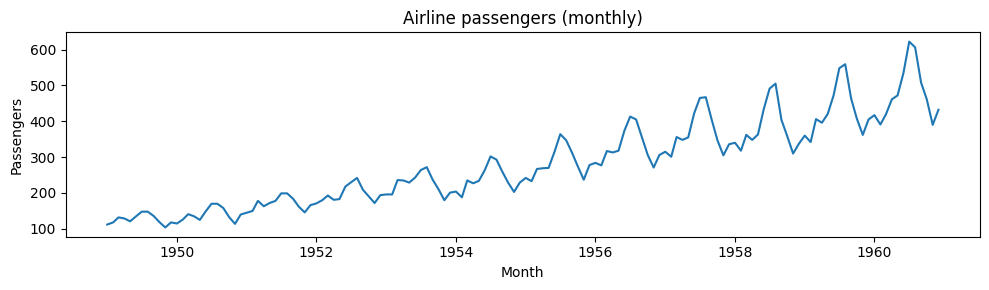

In [44]:
AIR_URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
ts = safe_read_csv(AIR_URL)
ts["Month"] = pd.to_datetime(ts["Month"])
ts = ts.rename(columns={"Passengers": "passengers"}).set_index("Month").sort_index()

plt.figure(figsize=(10, 3))
plt.plot(ts.index, ts["passengers"])
plt.title("Airline passengers (monthly)")
plt.xlabel("Month")
plt.ylabel("Passengers")
plt.tight_layout()
plt.show()


,passengers,month,lag_1,lag_12,roll_mean_12,target_next
Month,,,,,,
1950-01-01,115,1,118.0,112.0,126.666667,126.0
1950-02-01,126,2,115.0,118.0,126.916667,141.0
1950-03-01,141,3,126.0,132.0,127.583333,135.0
1950-04-01,135,4,141.0,129.0,128.333333,125.0
1950-05-01,125,5,135.0,121.0,128.833333,149.0


RMSE naive baseline: 51.82897282642619
RMSE regression w/ lags: 25.58199800869945


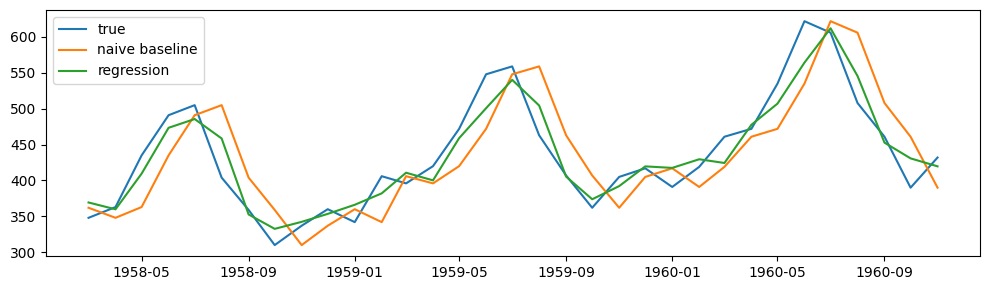

In [45]:
# Build a supervised table (very explicit)
from sklearn.metrics import mean_squared_error


df_ts = ts.copy()
df_ts["month"] = df_ts.index.month.astype(int)

# Features from the past
df_ts["lag_1"] = df_ts["passengers"].shift(1)
df_ts["lag_12"] = df_ts["passengers"].shift(12)
df_ts["roll_mean_12"] = df_ts["passengers"].shift(1).rolling(12).mean()

# Target: next month
df_ts["target_next"] = df_ts["passengers"].shift(-1)

# Remove rows that now have NaNs due to shifting/rolling
df_ts = df_ts.dropna()

display(df_ts.head())

# Chronological split (no shuffle)
X_ts = df_ts[["passengers","month","lag_1","lag_12","roll_mean_12"]].copy()
y_ts = df_ts["target_next"].copy()

split_idx = int(len(X_ts) * 0.75)
X_train_ts, X_test_ts = X_ts.iloc[:split_idx], X_ts.iloc[split_idx:]
y_train_ts, y_test_ts = y_ts.iloc[:split_idx], y_ts.iloc[split_idx:]

# Naive baseline
baseline_pred = X_test_ts["passengers"].values
rmse_base = mean_squared_error(y_test_ts, baseline_pred, squared=False)

# Simple regression (with pandas one-hot for month)
X_train_ts_ohe = pd.get_dummies(X_train_ts, columns=["month"], drop_first=True)
X_test_ts_ohe  = pd.get_dummies(X_test_ts, columns=["month"], drop_first=True)
X_train_ts_ohe, X_test_ts_ohe = X_train_ts_ohe.align(X_test_ts_ohe, join="left", axis=1, fill_value=0)

reg = LinearRegression()
reg.fit(X_train_ts_ohe, y_train_ts)
pred_ts = reg.predict(X_test_ts_ohe)
rmse_model = mean_squared_error(y_test_ts, pred_ts, squared=False)

print("RMSE naive baseline:", rmse_base)
print("RMSE regression w/ lags:", rmse_model)

plt.figure(figsize=(10, 3))
plt.plot(y_test_ts.index, y_test_ts.values, label="true")
plt.plot(y_test_ts.index, baseline_pred, label="naive baseline")
plt.plot(y_test_ts.index, pred_ts, label="regression")
plt.legend()
plt.tight_layout()
plt.show()


## C2) Text: from strings to numeric features (pandas-only features)

Before advanced NLP (TF–IDF/embeddings), it is useful to see that *even simple* text features can carry signal:
- message length
- number of digits (often higher in spam)
- contains certain keywords

This section is meant as an intuition-builder.


In [46]:
SMS_URL = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
sms = safe_read_csv(SMS_URL, sep="\t", header=None, names=["label","text"])
sms["text"] = sms["text"].astype(str)
sms["text_clean"] = sms["text"].str.lower().str.replace(r"\s+", " ", regex=True).str.strip()
sms["y"] = (sms["label"] == "spam").astype(int)

sms.sample(5, random_state=RANDOM_STATE)[["label","text","text_clean"]]


,label,text,text_clean
3245,ham,Squeeeeeze!! This is christmas hug.. If u lik ...,squeeeeeze!! this is christmas hug.. if u lik ...
944,ham,And also I've sorta blown him off a couple tim...,and also i've sorta blown him off a couple tim...
1044,ham,Mmm thats better now i got a roast down me! i...,mmm thats better now i got a roast down me! i...
2484,ham,Mm have some kanji dont eat anything heavy ok,mm have some kanji dont eat anything heavy ok
812,ham,So there's a ring that comes with the guys cos...,so there's a ring that comes with the guys cos...


,length,n_words,n_digits,n_exclaim,has_free,has_win,has_call
0,111,20,0,0,0,0,0
1,29,6,0,0,0,0,0
2,155,28,25,0,1,1,0
3,49,11,0,0,0,0,0
4,61,13,0,0,0,0,0


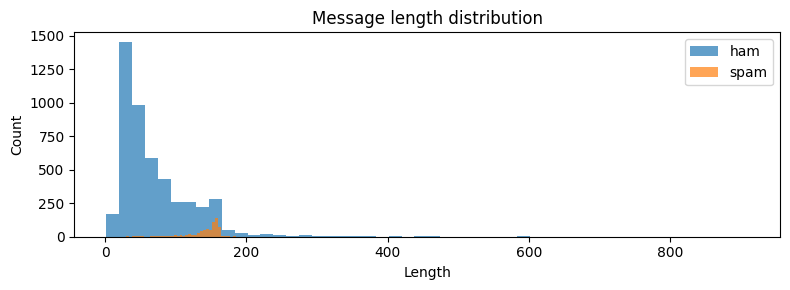

In [47]:
# Build simple numeric features from text (explicit and explainable)
feat = pd.DataFrame(index=sms.index)
feat["length"] = sms["text_clean"].str.len()
feat["n_words"] = sms["text_clean"].str.split().map(len)
feat["n_digits"] = sms["text_clean"].str.count(r"\d")
feat["n_exclaim"] = sms["text_clean"].str.count(r"!")
feat["has_free"] = sms["text_clean"].str.contains(r"\bfree\b").astype(int)
feat["has_win"]  = sms["text_clean"].str.contains(r"\bwin\b|\bwon\b").astype(int)
feat["has_call"] = sms["text_clean"].str.contains(r"\bcall\b").astype(int)

display(feat.head())

# Quick plot: length distribution
plt.figure(figsize=(8, 3))
plt.hist(feat.loc[sms["y"]==0, "length"], bins=50, alpha=0.7, label="ham")
plt.hist(feat.loc[sms["y"]==1, "length"], bins=50, alpha=0.7, label="spam")
plt.title("Message length distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


Accuracy: 0.9720028715003589


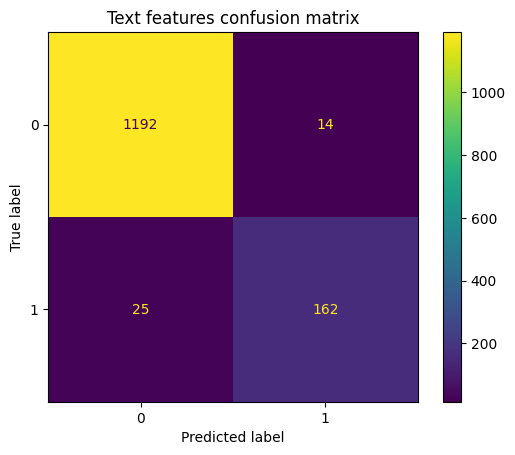

In [48]:
# Tiny model (only to show impact of representation)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    feat, sms["y"], test_size=0.25, random_state=RANDOM_STATE, stratify=sms["y"]
)

# Scaling numeric columns (z-score) with pandas
cols = feat.columns.tolist()
X_train_t_s, X_test_t_s = zscore_scale(X_train_t, X_test_t, cols)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_t_s, y_train_t)
pred = clf.predict(X_test_t_s)

print("Accuracy:", accuracy_score(y_test_t, pred))
ConfusionMatrixDisplay(confusion_matrix(y_test_t, pred)).plot()
plt.title("Text features confusion matrix")
plt.show()


## C3) Images: from pixels to a numeric row

Images are already numeric, but you still need:
- consistent size
- consistent intensity range

We load a single example image and show:
- raw pixel array shape
- normalization to [0,1]
- flattening to a 1D vector (classic ML baseline)


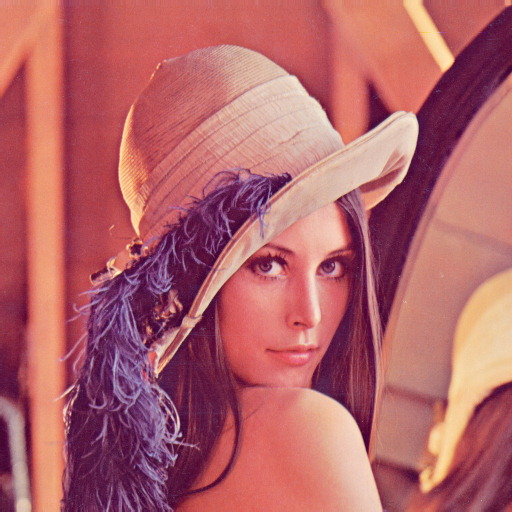

In [49]:
def load_image_from_url(url: str, timeout: int = 20) -> Image.Image:
    # Some hosts block requests without a User-Agent; GitHub raw is usually friendly.
    headers = {"User-Agent": "Mozilla/5.0 (AppliedML-Course/1.0)"}
    resp = requests.get(url, headers=headers, timeout=timeout)
    resp.raise_for_status()
    return Image.open(BytesIO(resp.content)).convert("RGB")

IMG_URL = "https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg"
img = load_image_from_url(IMG_URL)
img


Original shape (H, W, C): (512, 512, 3)
Original range: 0.0 to 255.0


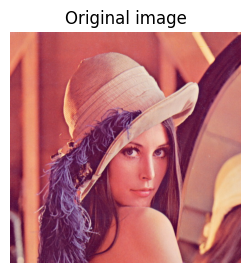

After preprocessing shape: (64, 64)
After preprocessing range: 0.12156862765550613 to 0.9215686321258545


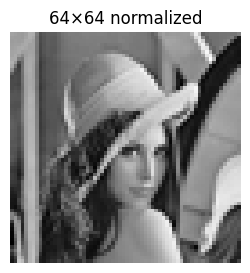

Flattened vector shape: (4096,)
DataFrame row shape: (1, 4096)


,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9
0,0.631373,0.623529,0.611765,0.603922,0.623529,0.670588,0.662745,0.513726,0.372549,0.403922


In [ ]:
arr = np.asarray(img).astype(np.float32)
print("Original shape (H, W, C):", arr.shape)
print("Original range:", float(arr.min()), "to", float(arr.max()))

plt.figure(figsize=(4, 3))
plt.imshow(arr.astype(np.uint8))
plt.title("Original image")
plt.axis("off")
plt.show()

# Preprocess: grayscale + resize + normalize
img_small = img.convert("L").resize((64, 64))
x_img = np.asarray(img_small, dtype=np.float32) / 255.0

print("After preprocessing shape:", x_img.shape)
print("After preprocessing range:", float(x_img.min()), "to", float(x_img.max()))

plt.figure(figsize=(3, 3))
plt.imshow(x_img, cmap="gray")
plt.title("64×64 normalized")
plt.axis("off")
plt.show()

x_vec = x_img.reshape(-1)
print("Flattened vector shape:", x_vec.shape)

# Convert to a single-row DataFrame (one row per sample)
row = pd.DataFrame([x_vec], columns=[f"px_{i}" for i in range(len(x_vec))])
print("DataFrame row shape:", row.shape)
row.iloc[:, :10]


# Final wrap-up 

### The repeatable workflow
1. Inspect small slices of raw data (avoid overwhelming output)
2. Identify issues: missing values, outliers, categories, scales
3. Apply transformations **with an explicit reason**
4. Verify with plots + simple sanity-check models
5. Keep train/test discipline: compute thresholds on train, apply to test

### Why this matters
Good preprocessing is often the difference between:
- “a model that fails / behaves strangely” and
- “a model that trains predictably and generalizes better”
